<a href="https://colab.research.google.com/github/yeonghun00/stock-notes/blob/main/analysis/Stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
code = '005930'
start_date = '20000101'
freq = 'month' # freq: day, week, month

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import datetime
import ast

class Stock:
  def __init__(self, code):
    self.code = code
    self.headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'}

  def get_price(self, start:int='20180501', interval='day'):
    url ='https://api.finance.naver.com/siseJson.naver?symbol=' + self.code + '&requestType=1&startTime=' \
    + start + '&endTime=' + str(datetime.datetime.now().date().strftime("%Y%m%d")) + '&timeframe=' + interval


    result = requests.get(url)
    bs_obj = BeautifulSoup(result.content, "html.parser")
    b = bs_obj.get_text()
    for i in ['\n', '\t', "\\", ' ']:
      b = b.replace(i,'')

    data = np.array(ast.literal_eval(b)[1:])

    dic = {'Date':list(map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'), data[:,0])), \
      'Open':np.array(data[:,1], float), 'High':np.array(data[:,2], float), 'Low':np.array(data[:,3], float),\
       'Close':np.array(data[:,4], float), 'Volume':np.array(data[:,5], float)}

    df = pd.DataFrame(data=dic)
    df = df.set_index('Date')
    return df
    
  def get_fundamental(self):
    url = 'https://finance.naver.com/item/main.nhn?code=' + self.code
    result = requests.get(url, headers = self.headers)
    bs_obj = BeautifulSoup(result.content, "html.parser")

    ths = bs_obj.find_all("th", {'scope':'col'})
    ths = [th.get_text() for th in ths][10:-22]
    dates = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),ths))
    dates = list(map(lambda x: x + '(Y)', dates[:4])) + list(map(lambda x: x + '(M)', dates[4:]))

    tr = bs_obj.find_all("tbody")
    tds = tr[2].find_all('td')
    tds = [td.get_text() for td in tds]
    elements = list(map(lambda x: x.translate(str.maketrans('','','\n\t, ')),tds))
    elements = list(map(lambda x: float(x) if x.replace('.','').isdigit() else np.nan, elements))

    temp_dict = {}
    cnt = 0
    index = ['sales', 'operating profit', 'net income', 'operating margin', 'net margin', 'roe', 'debt ratio', 'quick ratio', \
    'reserve ratio', 'eps', 'per', 'bps', 'pbr', 'dividend per share', 'dividend yield ratio', 'dividend payout ratio']

    for i in dates:
      temp_dict[i] = elements[cnt::10]
      cnt += 1

    df = pd.DataFrame.from_dict(temp_dict)
    df = df.set_index([pd.Index(index)])
    return df

In [3]:
stock = Stock(code)

In [4]:
stock_df = stock.get_price(start_date, freq)
stock_df['Change'] = stock_df['Close'][1:]/stock_df['Close'][:-1].values
stock_df = stock_df[1:]
stock_df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-02-29,5600.0,5960.0,4780.0,5120.0,21846955.0,0.917563
2000-03-31,5880.0,7680.0,5120.0,6700.0,25569119.0,1.308594
2000-04-28,6920.0,7499.0,5340.0,6000.0,17503285.0,0.895522
2000-05-31,6200.0,7340.0,5240.0,6160.0,21260173.0,1.026667
2000-06-30,6200.0,7739.0,6120.0,7380.0,21682724.0,1.198052
...,...,...,...,...,...,...
2022-05-31,66600.0,68800.0,64900.0,67400.0,310129252.0,1.000000
2022-06-30,66600.0,67300.0,56800.0,57000.0,428473209.0,0.845697
2022-07-29,56900.0,62600.0,55700.0,61400.0,301826933.0,1.077193


In [5]:
# stock
print('mean     : ', round(stock_df['Change'].mean(), 10))
print('var      : ', round(stock_df['Change'].var(), 10))
print('skewness : ', round(stock_df['Change'].skew(), 10))
print('kurtosis : ', round(stock_df['Change'].kurt(), 10))

mean     :  1.0125032759
var      :  0.0083546289
skewness :  0.3622596608
kurtosis :  1.7263906846


In [6]:
# market
market_df = Stock('KOSPI')
market_df = market_df.get_price(start_date, freq)
market_df['Change'] = market_df['Close'][1:]/market_df['Close'][:-1].values
market_df = market_df[1:]

# 주식 액면분할 날짜 제거
market_df = market_df.drop(index=market_df.index.difference(stock_df.index))

In [7]:
print('mean     : ', round(market_df['Change'].mean(), 10))
print('var      : ', round(market_df['Change'].var(), 10))
print('skewness : ', round(market_df['Change'].skew(), 10))
print('kurtosis : ', round(market_df['Change'].kurt(), 10))

mean     :  1.0051705561
var      :  0.0037948778
skewness :  -0.1602804129
kurtosis :  1.3128570387


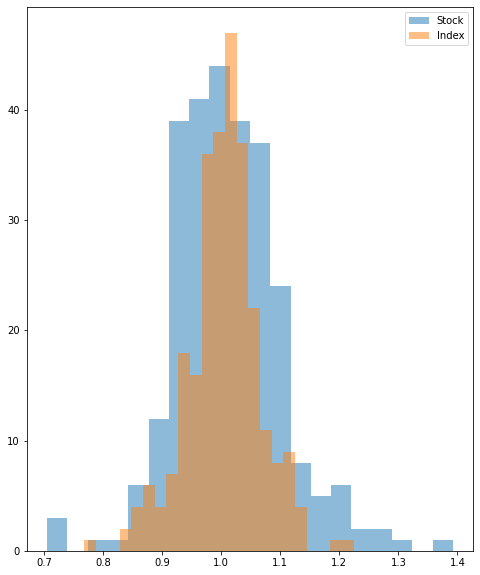

In [8]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(8, 10))
plt.hist(stock_df['Change'], bins= 'auto', alpha=0.5)
plt.hist(market_df['Change'], bins= 'auto', alpha=0.5)
plt.legend(['Stock', 'Index'])
plt.show()

In [9]:
# 샤프 비율: 변동성 대비 수익률
stock_return = stock_df['Change'].mean()
stock_return_std = stock_df['Change'].std()

# 무위험 이자율 (국채)
risk_free = 1.025
if freq == 'day': risk_free = risk_free**(1/250)
elif freq == 'week': risk_free = risk_free**(1/50)
elif freq == 'month': risk_free = risk_free**(1/12)

sharpe_ratio = (stock_return - risk_free)/stock_return_std
round(sharpe_ratio, 10)

0.1142562532

In [10]:
# 트레이너 비율: 시장위험 대비 수익률
cov = np.cov(np.array(stock_df['Change']), np.array(market_df['Change']))[0][1]
market_variance =  market_df['Change'].var()
beta = cov/market_variance

treynor_ratio = (stock_return - risk_free)/beta
round(treynor_ratio, 10)

0.0100050054

In [11]:
# 소르티노 비율: 가격 하락 변동성 대비 수익률
risk_free_min = risk_free
downside_std = stock_df[stock_df['Change'] < 1]['Change'].std()

sortino_ratio = (stock_return - risk_free_min)/downside_std
round(sortino_ratio, 10)

0.2021884518

In [12]:
# 젠센 알파: 실제 수익률 - CAPM 모델 예상 수익
market_return = market_df['Change'].mean()

jensens_alpha = stock_return - (risk_free + beta*(market_return - risk_free))
round(jensens_alpha, 10)

0.0071964034

In [13]:
# 정보 비율: 추적 오차(꾸준함) 대비 수익률 (- 벤치마크)
benchmark_return = market_return
tracking_error = (sum((stock_df['Change']-market_df['Change'])**2)/(len(stock_df.index)-1))**(1/2)

information_ratio = (stock_return - benchmark_return)/tracking_error
round(information_ratio, 10)

0.1120691783

In [14]:
print("Sharpe Ratio:      ", round(sharpe_ratio, 10))
print("Treynor Ratio:     ", round(treynor_ratio, 10))
print("Sortino Ratio:     ", round(sortino_ratio, 10))
print("Jensen's alpha:    ", round(jensens_alpha, 10))
print("Information Ratio: ", round(information_ratio, 10))

Sharpe Ratio:       0.1142562532
Treynor Ratio:      0.0100050054
Sortino Ratio:      0.2021884518
Jensen's alpha:     0.0071964034
Information Ratio:  0.1120691783


In [15]:
fundamental_df = stock.get_fundamental()
fundamental_df

,2019.12(Y),2020.12(Y),2021.12(Y),2022.12(E)(Y),2021.06(M),2021.09(M),2021.12(M),2022.03(M),2022.06(M),2022.09(E)(M)
sales,2304009.00,2368070.00,2796048.00,3136985.00,636716.00,739792.00,765655.00,777815.00,772036.00,789910.00
operating profit,277685.00,359939.00,516339.00,524190.00,125667.00,158175.00,138667.00,141214.00,140970.00,128550.00
net income,217389.00,264078.00,399074.00,412037.00,96345.00,122933.00,108379.00,113246.00,110988.00,106360.00
operating margin,12.05,15.20,18.47,16.71,19.74,21.38,18.11,18.15,18.26,16.27
net margin,9.44,11.15,14.27,13.13,15.13,16.62,14.16,14.56,14.38,13.46
roe,8.69,9.98,13.92,12.94,12.04,12.60,13.92,15.13,15.10,NaN
debt ratio,34.12,37.07,39.92,NaN,36.29,38.30,39.92,39.34,36.64,NaN
quick ratio,233.57,214.82,196.75,NaN,214.08,210.70,196.75,202.26,219.39,NaN
reserve ratio,28856.02,30692.79,33143.62,NaN,31140.36,32225.78,33143.62,34110.56,35054.68,NaN
eps,3166.00,3841.00,5777.00,5967.00,1391.00,1775.00,1567.00,1638.00,1613.00,1364.00


In [16]:
y_df = fundamental_df[list(filter(lambda x: 'Y' in x, fundamental_df))]
m_df = fundamental_df[list(filter(lambda x: 'M' in x, fundamental_df))]

In [17]:
def subplot_fundamental(li):
  fig, axs = plt.subplots(len(li), 2, gridspec_kw={'width_ratios': [4, 5]}, figsize=(20,10))
  fig.tight_layout(pad=3.0)
  for e in enumerate(li):
    for j in range(2):
      axs[e[0],j].title.set_text(e[1])
      if j == 0: 
        axs[e[0],j].plot(y_df.loc[e[1]])
        axs[e[0],j].axhline(y_df.loc[e[1]].mean(), color = 'r', linestyle = '--')
      elif j == 1: 
        axs[e[0],j].plot(m_df.loc[e[1]])
        axs[e[0],j].axhline(m_df.loc[e[1]].mean(), color = 'r', linestyle = '--')

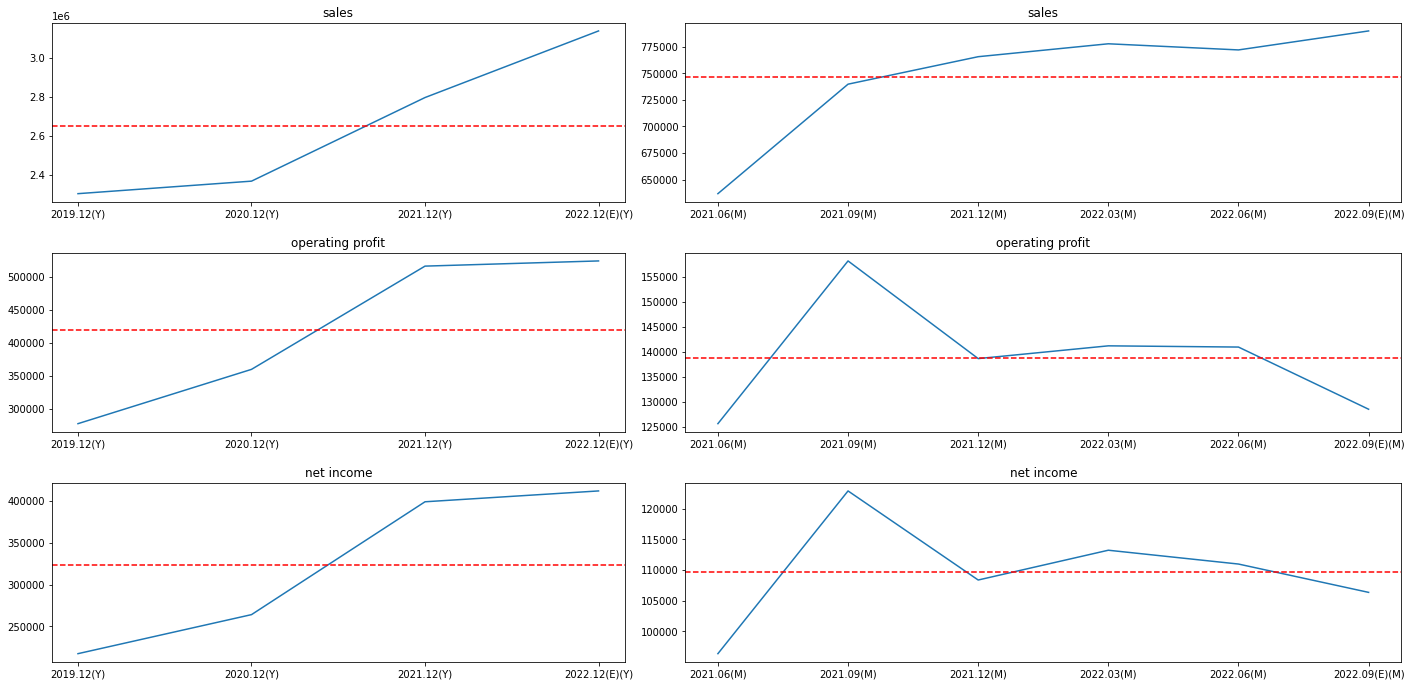

In [18]:
subplot_fundamental(['sales', 'operating profit', 'net income'])

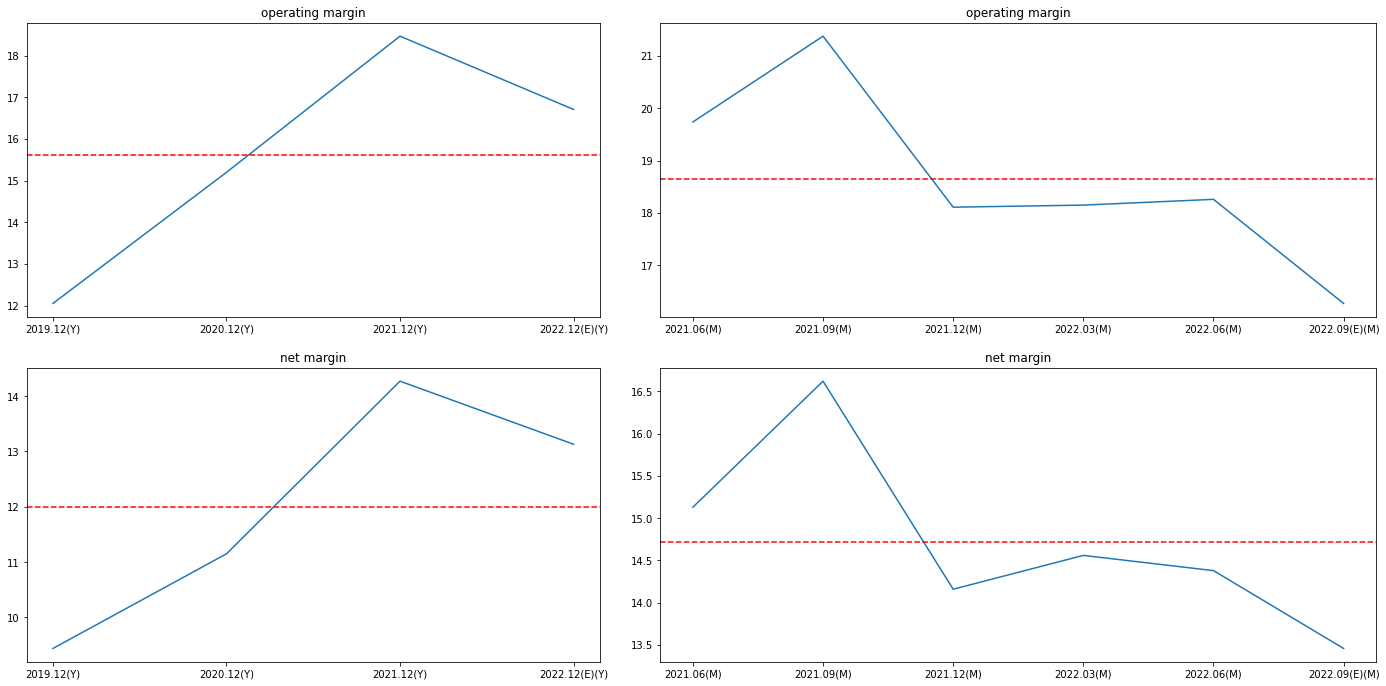

In [19]:
subplot_fundamental(['operating margin', 'net margin'])

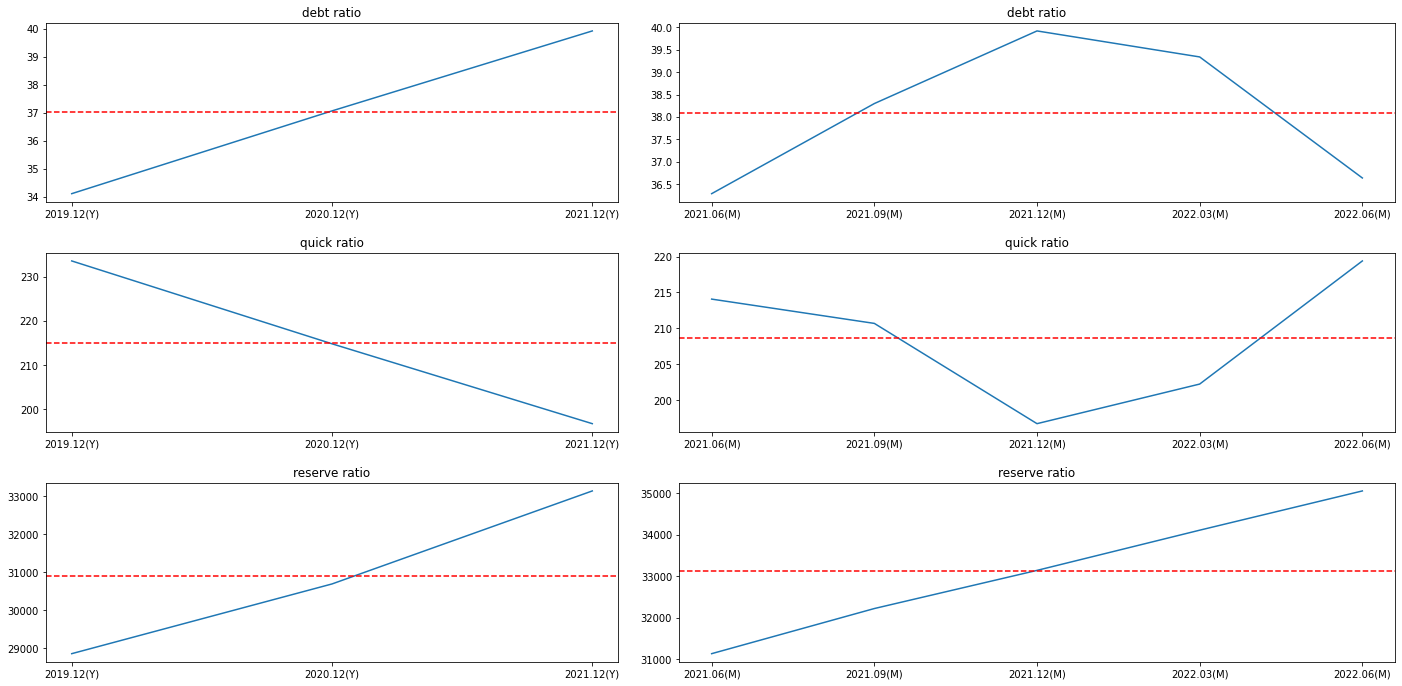

In [20]:
subplot_fundamental(['debt ratio', 'quick ratio', 'reserve ratio'])

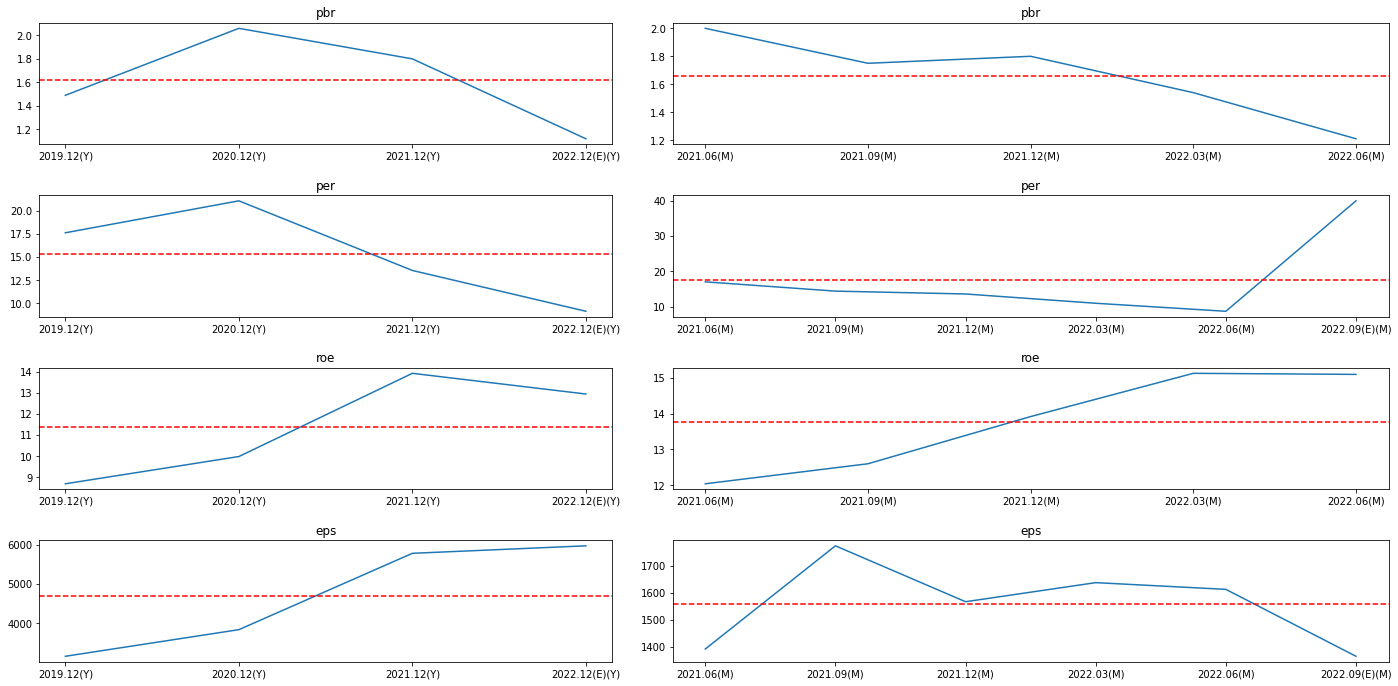

In [21]:
subplot_fundamental(['pbr', 'per', 'roe', 'eps'])

In [22]:
from dateutil import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt

class Analyser:
  def __init__(self, price_df, fundamental_df):
    self.price_df = price_df
    self.fundamental_df = fundamental_df[list(filter(lambda x: 'E' not in x, fundamental_df))]
    self.mixed_df = self.get_mixed_df()

  def find_date(self, year, month):
    # 결산일 고려 (2달)
    year,month = int(year), int(month)
    next = datetime.date(year,month,1) + relativedelta.relativedelta(months=2)
    year, month = next.year, next.month

    start = str(year) + '-' + str(month) + '-' + '01'
    end = str(year) + '-' + str(month) + '-' + '20'
    return self.price_df.loc[start:end].index.values[0]

  def get_mixed_df(self):
    price_dic = {}
    cnt = 0
    for i in [(x[:4], x[5:7]) for x in self.fundamental_df.columns.values]:
      try:
        price_dic[self.fundamental_df.columns.values[cnt]] = self.price_df.loc[self.find_date(i[0],i[1])]['Close']
      except:
        price_dic[self.fundamental_df.columns.values[cnt]] = 0
      cnt+=1
    return self.fundamental_df.append(pd.DataFrame(data=price_dic,  index = ['Price']))

  def get_heatmap(self):
    # correlation heatmap
    corrmat = self.mixed_df.transpose().corr().abs() 
    plt.subplots(figsize=(12,12))
    sns.heatmap(corrmat, annot = True)

  def get_influential(self, num=6):
    return self.get_mixed_df().transpose().corr()['Price'].sort_values(ascending = False).head(num)

In [23]:
stock_df = stock.get_price(start_date, 'day')
stock_df['Change'] = stock_df['Close'][1:]/stock_df['Close'][:-1].values

In [24]:
analyser = Analyser(stock_df, fundamental_df)

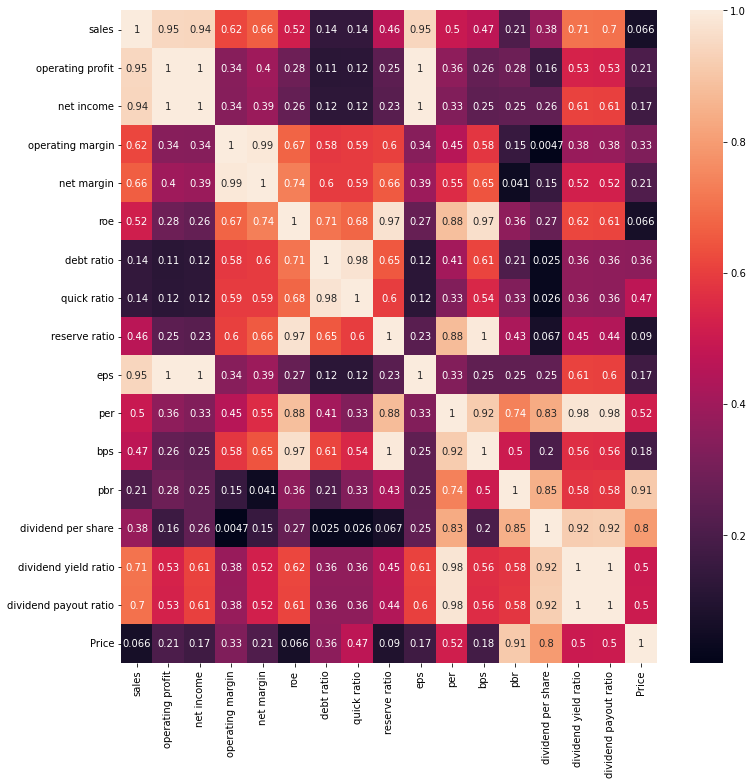

In [25]:
analyser.get_heatmap()

In [26]:
analyser.get_influential()[1:]

pbr                      0.912713
dividend per share       0.795874
per                      0.516272
dividend payout ratio    0.503281
dividend yield ratio     0.499632
Name: Price, dtype: float64